# ANAC


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize

#### Seed

In [36]:
seed = 2024
np.random.seed(seed)

In [37]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_5984/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [38]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
# merge whole df with own generated RecipeMatchesDiet

### Data Cleaning

#### Basics

In [39]:
# drop na diet column
df = df.dropna(subset=['Diet'])
# Rename AuthorId column
df.rename(columns= {
    "AuthorId" : "CustomerId", 
    "Time": "MaxTime"
}, inplace=True)

df["Like"] = df["Like"].astype("boolean")
# Change types into category and mapping values
df["Diet"] = df["Diet"].astype("category")

df["RecipeCategory"] = df["RecipeCategory"].astype("category")

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighCalories'] = df['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No' }
df['HighProtein'] = df['HighProtein'].map(mapping_protein).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['LowFat'] = df['LowFat'].map(mapping_cal).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No' }
df['LowSugar'] = df['LowSugar'].map(mapping_sugar).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighFiber'] = df['HighFiber'].map(mapping_cal).astype('category')

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)


# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=['Diet','RecipeCategory', 'HighCalories', 'LowFat', 'HighFiber', 'HighProtein', 'LowSugar'], drop_first=True)

df.rename(columns={
    'HighCalories_Yes': 'want_HighCalories',
    'LowFat_Yes':'want_LowFat',
    'HighFiber_Yes':'want_HighFiber',
    'HighProtein_Yes':'want_HighProtein',
}, inplace=True)

df["DifferenceRequestedAndTimeNeeded"] = df["MaxTime"] - (df["CookTime"] + df["PrepTime"])

In [40]:
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace(")", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("(", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\"", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\\", '')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].str.replace('^c', '', regex=True)

def check_keywords(ingredients):
    has_animal_product = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "milk", "butter", "egg", "cheese", "breast", "gelatin", "honey", "tuna", "steak", "salmon", "shrimps"]) for ingredient in ingredients)
    has_fish_or_meat = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "tuna", "steak", "salmon", 'shrimps']) for ingredient in ingredients)
    return has_animal_product, has_fish_or_meat

df[['has_animal_product', 'has_fish_meat']] = df['RecipeIngredientParts'].str.split(',').apply(check_keywords).apply(pd.Series)

df['for_Vegan'] = ~df['has_animal_product'] & ~df['has_fish_meat']
df['for_Vegetarian'] = (df['has_animal_product'] & ~df['has_fish_meat']) | (~df['has_animal_product'] & ~df['has_fish_meat'])
df['Correct_Diet'] = (~df['Diet_Vegetarian'] & ~df['Diet_Vegan']) | (df['Diet_Vegan'] & df['for_Vegan']) | (df['Diet_Vegetarian']  & df['for_Vegetarian'] )



***Split data***

In [41]:
# Split data into train and test set
train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

# Handling outliers

In [42]:
train_set = train_set[train_set["Calories"] < 300000]

### Missing values

In [43]:
train_set.dropna(subset=["Like"], inplace=True)
train_set = train_set.drop("TestSetId", axis=1)

In [44]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set.loc[:, 'RecipeServings'] = train_set['RecipeServings'].fillna(recipesServings_mean)
test_set.loc[:, 'RecipeServings'] = test_set['RecipeServings'].fillna(recipesServings_mean)

***Train Model***


In [45]:
from sklearn.utils.class_weight import compute_class_weight
#Variables that are good according to xgboost: 

#variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', "Calories", "SaturatedFatContent", "SugarContent", "CookTime", "PrepTime", "Diet_Vegan", "Diet_Vegetarian", "RecipeCategory_Bread", "RecipeCategory_Other", "RecipeCategory_Breakfast", "RecipeCategory_Lunch", "RecipeCategory_Soup", "RecipeCategory_One dish meal", "LowSugar_No", "CholesterolContent", "SodiumContent", "FiberContent", "RecipeServings", "Time", "HighCalories", "HighFiber"]

variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product']
X = train_set.drop(variables_to_drop, axis=1)
y = train_set['Like']
test_set = test_set.drop(variables_to_drop, axis=1)

In [46]:
from sklearn.utils.class_weight import compute_class_weight

#classes = np.unique(y)
#class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

# Create a dictionary for class weights
#class_weights_dict = {i: class_weights[i] for i in range(len(classes))}

#print("Class Weights:", class_weights_dict)

In [47]:
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=seed)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [48]:
train_model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=7, random_state=seed)
train_model.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=400, random_state=2024)

In [49]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

         Like  Predicted_Like  Probability_Like=0  Probability_Like=1
57595   False             0.0            0.515270            0.484730
45723   False             0.0            0.943159            0.056841
86478   False             0.0            0.981209            0.018791
133143  False             0.0            0.977091            0.022909
65385   False             0.0            0.997696            0.002304
...       ...             ...                 ...                 ...
80133   False             0.0            0.972907            0.027093
58468   False             1.0            0.008582            0.991418
86921   False             0.0            0.999652            0.000348
95676   False             1.0            0.112739            0.887261
115763  False             0.0            0.990276            0.009724

[29214 rows x 4 columns]
Confusion Matrix:
[[20965  4354]
 [  547  3348]]
Test-Precision: 0.434692287717476
Test-Accuracy: 0.8322379680974875
Test-Recall: 0.85

0.7466979011484827
7419581036855475

with scaling on all X params
Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3}
Best Score: 0.7401457209763812

with scaling on selected X params
Best Parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}
Best Score: 0.7413614412190518

7465201538002812

Test Balanced Accuracy: 0.8437989127792271


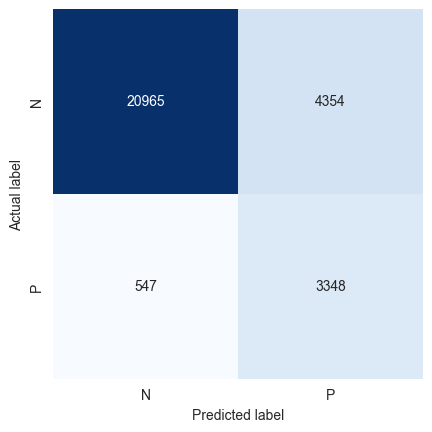

In [50]:
from sklearn.metrics import confusion_matrix
 
y_predicted = train_model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc = balanced_accuracy_score(y_test, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc}')

***Output file with test set***

In [51]:
test_set["prediction"] = train_model.predict(test_set.drop("TestSetId", axis=1))
test_output = pd.DataFrame(columns=["id", "prediction"])
test_output["id"] = test_set["TestSetId"].astype(int)
test_output["prediction"] = test_set["prediction"].astype(int)
test_output.to_csv("predictions_LetsSeePaulAllens'BAC_4.csv", index=False)